# Live Stock Movement Predictor
Predicting **next-day direction** (up/down) for multiple tickers using live Yahoo Finance data and technical indicators.


## 0. Notebook Setup
This notebook is designed to run top-to-bottom without manual edits. If any package is missing, we install it.


In [1]:
# %%pip install --quiet yfinance xgboost shap ta scikit-learn matplotlib seaborn pandas numpy vaderSentiment
import importlib
import subprocess
import sys
import os
import warnings
import time
import requests
from datetime import timedelta
from datetime import datetime

REQUIRED_PACKAGES = {
    'yfinance': 'yfinance',
    'xgboost': 'xgboost',
    'shap': 'shap',
    'ta': 'ta',
    'scikit-learn': 'sklearn',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'pandas': 'pandas',
    'numpy': 'numpy',
    'vaderSentiment': 'vaderSentiment',
}

def ensure_packages(package_map):
    for pkg, module_name in package_map.items():
        try:
            importlib.import_module(module_name)
        except ImportError:
            print(f'Installing missing package: {pkg}')
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '--quiet'])

ensure_packages(REQUIRED_PACKAGES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)


In [2]:
MARKETAUX_API_KEY = os.getenv('MARKETAUX_API_KEY', 'EBNHGy6u12hpPiXniiUWkIfagtvs37bbIO0enZ8t')

def fetch_news_sentiment(ticker, pages=3, per_page=100):
    if not MARKETAUX_API_KEY:
        return pd.DataFrame(columns=['Ticker', 'Date', 'sentiment_score'])
    records = []
    base_url = 'https://api.marketaux.com/v1/news/all'
    for page in range(1, pages + 1):
        params = {
            'symbols': ticker,
            'limit': per_page,
            'page': page,
            'language': 'en',
            'api_token': MARKETAUX_API_KEY,
            'sort': 'published_desc'
        }
        try:
            response = requests.get(base_url, params=params, timeout=15)
            response.raise_for_status()
            payload = response.json()
            items = payload.get('data', [])
            if not items:
                break
            for item in items:
                published = item.get('published_at') or item.get('published_time')
                if not published:
                    continue
                published = pd.to_datetime(published).tz_localize(None).normalize()
                entities = item.get('entities') or []
                matched = [e for e in entities if isinstance(e, dict) and e.get('symbol', '').upper() == ticker.upper()]
                if not matched:
                    continue
                for entity in matched:
                    score = entity.get('sentiment_score')
                    if score is None:
                        continue
                    try:
                        score = float(score)
                    except (TypeError, ValueError):
                        continue
                    records.append({
                        'Ticker': ticker,
                        'Date': published,
                        'sentiment_score': score
                    })
            if len(items) < per_page:
                break
            time.sleep(0.2)
        except Exception:
            break
    if not records:
        return pd.DataFrame(columns=['Ticker', 'Date', 'sentiment_score'])
    sentiment_df = pd.DataFrame(records)
    sentiment_df = sentiment_df.groupby(['Ticker', 'Date'])['sentiment_score'].mean().reset_index()
    return sentiment_df


## 1. Introduction
- **Goal:** Predict whether **tomorrow's close** will be **higher** than today's for a diversified equity basket.
- **Universe:** AAPL, MSFT, GOOG, TSLA, NVDA, AMZN — fetched from inception using `period='max'`.
- **Approach:** Build technical features from daily OHLCV data; train **XGBoost** classifier; evaluate on chronological splits; interpret with **SHAP**.
- **Why:** Assess a multi-name directional signal using transparent, reproducible features and class-balanced training.


## 2. Data Acquisition (Live)
We fetch 8–10 years of daily OHLCV using **yfinance**. Adjust tickers/dates as needed.


In [3]:
import yfinance as yf

TICKERS = ['AAPL', 'MSFT', 'GOOG', 'TSLA', 'NVDA', 'AMZN']
START = None  # use full history per ticker
END = None

SENTIMENT_CACHE = {ticker: fetch_news_sentiment(ticker) for ticker in TICKERS}

def download_ticker(ticker, start=START, end=END):
    df = yf.download(
        ticker,
        start=start,
        end=end,
        progress=False,
        auto_adjust=False,
        group_by='column',
        threads=False,
        period='max'
    )
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = df.reset_index()
    df = df.rename(columns=lambda c: c.replace(' ', '') if isinstance(c, str) else c)
    df['Ticker'] = ticker
    sentiment_df = SENTIMENT_CACHE.get(ticker)
    if sentiment_df is not None and not sentiment_df.empty:
        sentiment_df = sentiment_df.rename(columns={'Date': 'Date_norm'})
        df['Date_norm'] = df['Date'].dt.normalize()
        df = df.merge(sentiment_df, on=['Ticker', 'Date_norm'], how='left')
        df.drop(columns=['Date_norm'], inplace=True)
    else:
        df['sentiment_score'] = 0.0
    if 'sentiment_score' not in df:
        df['sentiment_score'] = 0.0
    df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce').fillna(0.0)
    return df

raw_frames = [download_ticker(t) for t in TICKERS]
prices = pd.concat(raw_frames, ignore_index=True)
prices.sort_values(['Ticker', 'Date'], inplace=True)
prices.head()


,Date,AdjClose,Close,High,Low,Open,Volume,Ticker,sentiment_score
0,1980-12-12,0.098485,0.128348,0.128906,0.128348,0.128348,469033600,AAPL,0.0
1,1980-12-15,0.093347,0.121652,0.122210,0.121652,0.122210,175884800,AAPL,0.0
2,1980-12-16,0.086495,0.112723,0.113281,0.112723,0.113281,105728000,AAPL,0.0
3,1980-12-17,0.088636,0.115513,0.116071,0.115513,0.115513,86441600,AAPL,0.0
4,1980-12-18,0.091206,0.118862,0.119420,0.118862,0.118862,73449600,AAPL,0.0


## 2a. Exploratory Analysis
Before crafting indicators, we inspect the raw OHLCV data to understand coverage, scale, and basic price/volume dynamics that motivate the chosen features.


In [4]:
# Coverage and basic integrity checks
coverage = (prices.groupby('Ticker')['Date']
            .agg(['min', 'max', 'count'])
            .rename(columns={'min': 'start', 'max': 'end', 'count': 'rows'}))
missing_pct = prices.isna().mean().round(4) * 100
print('Observation window per ticker:')
display(coverage)
print('Missing values (% of rows) across raw columns:')
display(missing_pct.to_frame('pct_missing'))


Observation window per ticker:


,start,end,rows
Ticker,,,
AAPL,1980-12-12,2025-10-24,11309
AMZN,1997-05-15,2025-10-24,7157
GOOG,2004-08-19,2025-10-24,5331
MSFT,1986-03-13,2025-10-24,9983
NVDA,1999-01-22,2025-10-24,6732
TSLA,2010-06-29,2025-10-24,3856


Missing values (% of rows) across raw columns:


,pct_missing
Date,0.0
AdjClose,0.0
Close,0.0
High,0.0
Low,0.0
Open,0.0
Volume,0.0
Ticker,0.0
sentiment_score,0.0


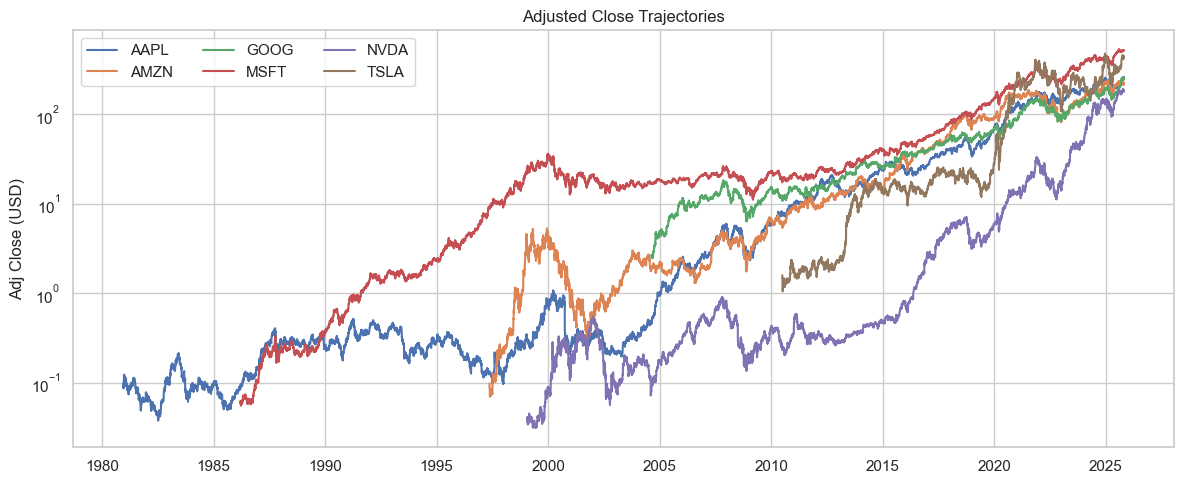

In [5]:
# Price evolution (log scale helps compare different price levels)
fig, ax = plt.subplots(figsize=(12, 5))
for ticker, grp in prices.groupby('Ticker'):
    ax.plot(grp['Date'], grp['AdjClose'], label=ticker)
ax.set_title('Adjusted Close Trajectories')
ax.set_ylabel('Adj Close (USD)')
ax.set_yscale('log')
ax.legend(loc='upper left', ncol=3)
plt.tight_layout()
plt.show()


Return distribution summary:


,mean,std,min,max
Ticker,,,,
AAPL,0.001088,0.027694,-0.518692,0.332280
AMZN,0.001680,0.034931,-0.247661,0.344714
GOOG,0.001059,0.019313,-0.116091,0.199915
MSFT,0.001130,0.020935,-0.301159,0.195653
NVDA,0.001968,0.037632,-0.352336,0.424148
TSLA,0.002117,0.036482,-0.210628,0.243951


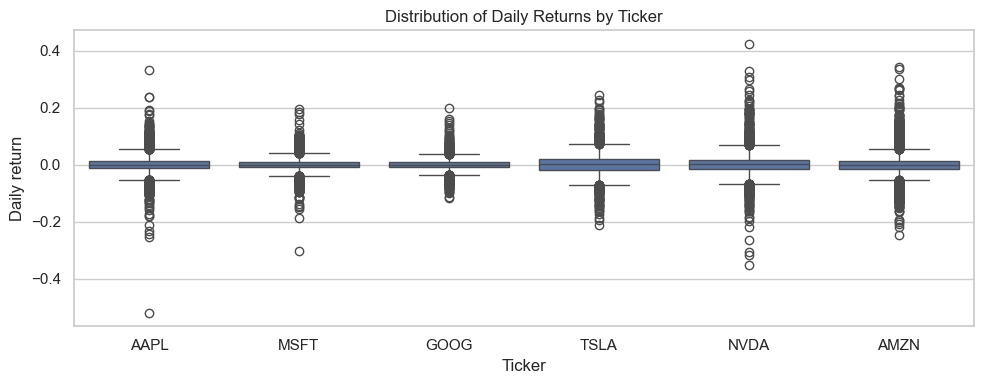

In [6]:
# Daily returns and volatility snapshots
returns = (prices.sort_values('Date')
           .groupby('Ticker')
           ['AdjClose'].pct_change().rename('ret1d'))
volatility = (returns.groupby(prices['Ticker'])
              .agg(['mean', 'std']))
volatility.columns = ['mean_ret', 'std_ret']
print('Return distribution summary:')
display(returns.groupby(prices['Ticker']).describe()[['mean', 'std', 'min', 'max']])
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=prices['Ticker'], y=returns, ax=ax)
ax.set_title('Distribution of Daily Returns by Ticker')
ax.set_ylabel('Daily return')
plt.tight_layout()
plt.show()


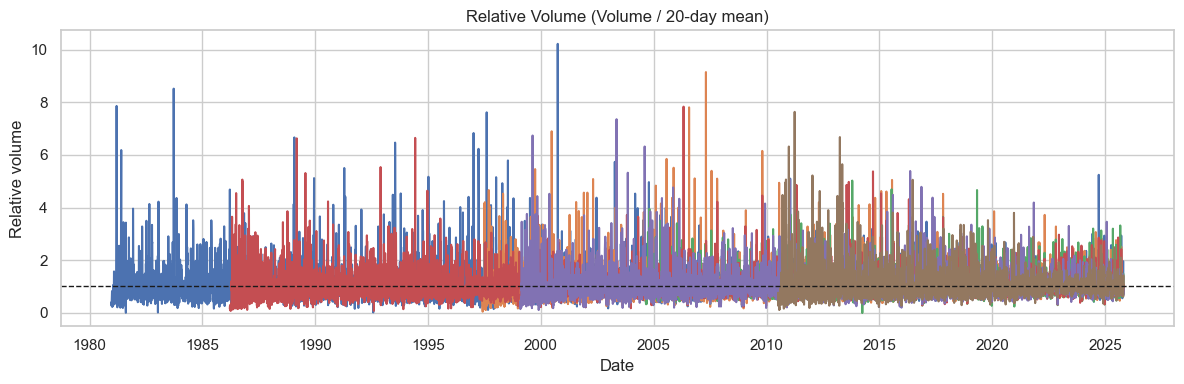

In [7]:
# Volume dynamics to motivate relative-volume features
volume_rolling = (prices.sort_values('Date')
                  .groupby('Ticker')['Volume']
                  .rolling(window=20, min_periods=5)
                  .mean()
                  .reset_index(level=0, drop=True))
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(x=prices['Date'], y=prices['Volume'] / volume_rolling, hue=prices['Ticker'], ax=ax, legend=False)
ax.set_title('Relative Volume (Volume / 20-day mean)')
ax.set_ylabel('Relative volume')
ax.axhline(1.0, color='k', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()


## 3. Feature Engineering (Technical Indicators)
We compute standard indicators. If `ta` is unavailable, we implement fallbacks.

**Features per ticker:**
- `ret1d`: one-day log-adjusted return measuring momentum.
- `std_w`: rolling standard deviation over the past `w` days (w ∈ {5, 10, 15, 20}) capturing short-term volatility.
- `bb_width`: Bollinger Band width using a 20-day mean and ±2σ envelope to quantify price dispersion.
- `vol_chg`: day-over-day percentage change in volume for flow sensitivity.
- `rel_vol20`: ratio of today’s volume to the 20-day average, highlighting unusual activity.
- `rsi14`: 14-day Relative Strength Index gauging overbought/oversold momentum.
- `macd`: Moving Average Convergence Divergence (12/26 exponential spans) momentum oscillator.
- `macd_hist`: MACD histogram (macd − signal) reflecting momentum acceleration.
- `atr14`: 14-day Average True Range capturing range-based volatility.
Target is `1` if next-day Close > today Close, else `0`.


In [8]:
try:
    import ta
    HAVE_TA = True
except Exception:
    HAVE_TA = False

def add_features(df):
    df = df.sort_values("Date").copy()
    df["ret1d"] = df["AdjClose"].pct_change()
    for w in [5, 10, 15, 20]:
        df[f"sma_{w}"] = df["AdjClose"].rolling(w, min_periods=w).mean()
        df[f"std_{w}"] = df["AdjClose"].rolling(w, min_periods=w).std()
    df["bb_mid"] = df["AdjClose"].rolling(20, min_periods=20).mean()
    df["bb_std"] = df["AdjClose"].rolling(20, min_periods=20).std()
    df["bb_upper"] = df["bb_mid"] + 2*df["bb_std"]
    df["bb_lower"] = df["bb_mid"] - 2*df["bb_std"]
    df["bb_width"] = (df["bb_upper"] - df["bb_lower"]) / df["bb_mid"]
    df["vol_chg"] = df["Volume"].pct_change()
    df["vol_sma20"] = df["Volume"].rolling(20, min_periods=20).mean()
    df["rel_vol20"] = df["Volume"] / df["vol_sma20"]
    if HAVE_TA:
        df["rsi14"] = ta.momentum.RSIIndicator(close=df["AdjClose"], window=14).rsi()
        macd = ta.trend.MACD(close=df["AdjClose"], window_slow=26, window_fast=12, window_sign=9)
        df["macd"] = macd.macd()
        df["macd_signal"] = macd.macd_signal()
        df["macd_hist"] = macd.macd_diff()
        atr = ta.volatility.AverageTrueRange(high=df["High"], low=df["Low"], close=df["AdjClose"], window=14)
        df["atr14"] = atr.average_true_range()
    else:
        delta = df["AdjClose"].diff()
        up = delta.clip(lower=0)
        down = -1*delta.clip(upper=0)
        roll_up = up.rolling(14, min_periods=14).mean()
        roll_down = down.rolling(14, min_periods=14).mean()
        rs = roll_up / roll_down
        df["rsi14"] = 100 - (100 / (1 + rs))
        ema12 = df["AdjClose"].ewm(span=12, adjust=False).mean()
        ema26 = df["AdjClose"].ewm(span=26, adjust=False).mean()
        df["macd"] = ema12 - ema26
        df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()
        df["macd_hist"] = df["macd"] - df["macd_signal"]
        tr1 = (df['High'] - df['Low']).abs()
        tr2 = (df['High'] - df['AdjClose'].shift()).abs()
        tr3 = (df['Low'] - df['AdjClose'].shift()).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        df["atr14"] = tr.rolling(14, min_periods=14).mean()
    df["target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    return df

feat = prices.groupby("Ticker", group_keys=False).apply(add_features)
feat.head()


,Date,AdjClose,Close,High,Low,Open,Volume,Ticker,sentiment_score,ret1d,...,bb_width,vol_chg,vol_sma20,rel_vol20,rsi14,macd,macd_signal,macd_hist,atr14,target
0,1980-12-12,0.098485,0.128348,0.128906,0.128348,0.128348,469033600,AAPL,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1,1980-12-15,0.093347,0.121652,0.122210,0.121652,0.122210,175884800,AAPL,0.0,-0.052170,...,NaN,-0.625006,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2,1980-12-16,0.086495,0.112723,0.113281,0.112723,0.113281,105728000,AAPL,0.0,-0.073398,...,NaN,-0.398879,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
3,1980-12-17,0.088636,0.115513,0.116071,0.115513,0.115513,86441600,AAPL,0.0,0.024751,...,NaN,-0.182415,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
4,1980-12-18,0.091206,0.118862,0.119420,0.118862,0.118862,73449600,AAPL,0.0,0.028992,...,NaN,-0.150298,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1


In [9]:
TRAIN_FRAC = 0.7
VAL_FRAC = 0.15
TEST_FRAC = 1 - TRAIN_FRAC - VAL_FRAC

def split_ticker_by_time(df, feature_list, train_frac=TRAIN_FRAC, val_frac=VAL_FRAC):
    df = df.dropna(subset=feature_list + ['target']).copy()
    n = len(df)
    if n == 0:
        empty = df.iloc[0:0]
        return empty, empty, empty
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))
    boundaries = []
    if 0 < train_end < n:
        boundaries.append(train_end)
    if 0 < val_end < n and val_end not in boundaries:
        boundaries.append(val_end)
    boundaries = sorted(boundaries)
    splits = np.split(df, boundaries)
    if len(splits) == 1:
        train, val, test = splits[0], df.iloc[0:0], df.iloc[0:0]
    elif len(splits) == 2:
        train, val = splits
        test = df.iloc[0:0]
    else:
        train, val, test = splits
    if len(val) == 0 and len(test) > 1:
        val = test.iloc[:1]
        test = test.iloc[1:]
    if len(test) == 0 and len(val) > 1:
        test = val.iloc[-1:]
        val = val.iloc[:-1]
    return train, val, test


## 4. Chronological Split (Train/Val/Test)
We split each ticker chronologically (70/15/15) so class balance reflects per-ticker availability before pooling into global train/validation/test sets.


### Gap Selection — SMA/STD Window
We evaluate single smoothing windows (5, 10, 15, 20) — keeping one rolling mean and one rolling std feature at a time — to identify the option that maximizes out-of-sample accuracy.


In [10]:
def balance_by_class(df, label='target', group_key='Ticker', random_state=42):
    """Down-sample the majority class within each ticker to avoid leakage from duplicated rows."""
    balanced_parts = []
    for ticker, grp in df.groupby(group_key):
        counts = grp[label].value_counts()
        if len(counts) < 2:
            balanced_parts.append(grp)
            continue
        min_count = counts.min()
        for cls, sub in grp.groupby(label):
            if len(sub) > min_count:
                balanced_parts.append(sub.sample(min_count, random_state=random_state))
            else:
                balanced_parts.append(sub)
    if not balanced_parts:
        return df.copy()
    return (pd.concat(balanced_parts)
            .sample(frac=1.0, random_state=random_state)
            .reset_index(drop=True))


In [11]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

GAP_OPTIONS = [5, 10, 15, 20]
gap_results = []

for gap in GAP_OPTIONS:
    feature_set = ['ret1d', 'bb_width', 'vol_chg', 'rel_vol20', 'rsi14', 'macd', 'macd_hist', 'atr14', f'std_{gap}']
    trains, vals, tests = [], [], []
    for ticker, group in feat.groupby('Ticker'):
        tr, val, te = split_ticker_by_time(group, feature_set)
        if len(tr) == 0 or len(val) == 0:
            continue
        trains.append(tr)
        vals.append(val)
        tests.append(te)
    if not trains or not vals:
        continue
    train_tmp = pd.concat(trains)
    train_tmp = balance_by_class(train_tmp)  # keep training folds class-balanced
    train_tmp = train_tmp.replace([np.inf, -np.inf], np.nan)
    train_tmp = train_tmp.dropna(subset=feature_set + ['target'])
    val_tmp = pd.concat(vals)
    X_val_tmp = val_tmp[feature_set]
    y_val_tmp = val_tmp['target']
    model_tmp = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        n_jobs=-1,
        eval_metric='logloss',
        random_state=42,
        base_score=0.5
    )
    train_tmp = train_tmp.reset_index(drop=True)
    X_train_tmp = train_tmp[feature_set]
    y_train_tmp = train_tmp['target']
    model_tmp.fit(X_train_tmp, y_train_tmp)
    acc_tmp = accuracy_score(y_val_tmp, model_tmp.predict(X_val_tmp))
    gap_results.append({
        'window': gap,
        'accuracy': acc_tmp,
        'train_size': len(train_tmp),
        'val_size': len(val_tmp),
        'test_size': sum(len(te) for te in tests)
    })

gap_df = pd.DataFrame(gap_results).sort_values('accuracy', ascending=False).reset_index(drop=True)
display(gap_df)
BEST_WINDOW = int(gap_df.iloc[0]['window']) if not gap_df.empty else 10
print(f'Chosen smoothing window: {BEST_WINDOW}')


,window,accuracy,train_size,val_size,test_size
0,20,0.510038,30351,6625,6628
1,15,0.508075,30351,6625,6628
2,10,0.506566,30351,6625,6628
3,5,0.505358,30351,6625,6628


Chosen smoothing window: 20


In [12]:
CORE_FEATURES = ['ret1d', 'bb_width', 'vol_chg', 'rel_vol20', 'rsi14', 'macd', 'macd_hist', 'atr14']
FEATURES = CORE_FEATURES + [f'std_{BEST_WINDOW}']

train_parts, val_parts, test_parts = [], [], []
for ticker, group in feat.groupby('Ticker'):
    tr, val, te = split_ticker_by_time(group, FEATURES)
    if len(tr):
        train_parts.append(tr)
    if len(val):
        val_parts.append(val)
    if len(te):
        test_parts.append(te)

train_df = pd.concat(train_parts).reset_index(drop=True) if train_parts else pd.DataFrame(columns=feat.columns)
val_df = pd.concat(val_parts).reset_index(drop=True) if val_parts else pd.DataFrame(columns=feat.columns)
test_df = pd.concat(test_parts).reset_index(drop=True) if test_parts else pd.DataFrame(columns=feat.columns)
frames = [df for df in (train_df, val_df) if not df.empty]
trainval_df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=feat.columns)
print(f'Using std window {BEST_WINDOW} with features: {FEATURES}')
print(f'Train/Val/Test sizes: {len(train_df)}, {len(val_df)}, {len(test_df)}')


Using std window 20 with features: ['ret1d', 'bb_width', 'vol_chg', 'rel_vol20', 'rsi14', 'macd', 'macd_hist', 'atr14', 'std_20']
Train/Val/Test sizes: 30917, 6625, 6628


In [13]:
train_balanced_df = balance_by_class(train_df)
train_balanced_df = (train_balanced_df
                      .replace([np.inf, -np.inf], np.nan)
                      .dropna(subset=FEATURES + ['target'])
                      .reset_index(drop=True))
print(f'Balanced train size: {len(train_balanced_df)} (was {len(train_df)})')


Balanced train size: 30351 (was 30917)


### Class Distribution Check
We confirm each ticker contributes proportionally to the pooled train/validation/test splits and inspect the up/down balance.


In [14]:
def summarize_classes(df, name):
    if df.empty:
        print(f'{name}: no samples available.')
        return
    table = (df.groupby(['Ticker', 'target']).size()
             .unstack(fill_value=0)
             .rename(columns={0: 'down', 1: 'up'}))
    table['total'] = table.sum(axis=1)
    table['up_pct'] = (table['up'] / table['total']).round(3)
    display(table)
    mean_up = df['target'].mean()
    print(f"{name} up-rate: {mean_up:.3f} across {len(df)} samples")

summarize_classes(train_df, 'Train (raw)')
summarize_classes(train_balanced_df, 'Train (balanced)')
summarize_classes(val_df, 'Validation')
summarize_classes(test_df, 'Test')


target,down,up,total,up_pct
Ticker,,,,
AAPL,4050,3843,7893,0.487
AMZN,2485,2501,4986,0.502
GOOG,1790,1918,3708,0.517
MSFT,3514,3451,6965,0.495
NVDA,2314,2375,4689,0.507
TSLA,1293,1383,2676,0.517


Train (raw) up-rate: 0.500 across 30917 samples


target,down,up,total,up_pct
Ticker,,,,
AAPL,3842,3843,7685,0.5
AMZN,2485,2485,4970,0.5
GOOG,1790,1790,3580,0.5
MSFT,3451,3451,6902,0.5
NVDA,2314,2314,4628,0.5
TSLA,1293,1293,2586,0.5


Train (balanced) up-rate: 0.500 across 30351 samples


target,down,up,total,up_pct
Ticker,,,,
AAPL,818,873,1691,0.516
AMZN,479,590,1069,0.552
GOOG,353,442,795,0.556
MSFT,701,791,1492,0.530
NVDA,456,549,1005,0.546
TSLA,266,307,573,0.536


Validation up-rate: 0.536 across 6625 samples


target,down,up,total,up_pct
Ticker,,,,
AAPL,784,908,1692,0.537
AMZN,526,543,1069,0.508
GOOG,363,432,795,0.543
MSFT,700,793,1493,0.531
NVDA,467,538,1005,0.535
TSLA,288,286,574,0.498


Test up-rate: 0.528 across 6628 samples


### Covariance Diagnostics
We examine the covariance and correlation structure of engineered features on the training set to flag highly interdependent signals.
This informs which smoothing horizons (5, 10, 15, 20) we should prioritize before the gap search that follows.


,ret1d,bb_width,vol_chg,rel_vol20,rsi14,macd,macd_hist,atr14,std_20
ret1d,0.0010,0.0001,NaN,0.0016,0.1248,0.0006,0.0004,-0.0012,0.0003
bb_width,0.0001,0.0191,NaN,0.0010,0.0187,0.0089,0.0019,-0.0656,0.0251
vol_chg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rel_vol20,0.0016,0.0010,NaN,0.2861,0.3045,-0.0032,0.0001,-0.0086,0.0006
rsi14,0.1248,0.0187,NaN,0.3045,159.2698,2.7686,0.6035,-1.2524,0.8320
macd,0.0006,0.0089,NaN,-0.0032,2.7686,0.8448,0.0665,0.2895,0.6548
macd_hist,0.0004,0.0019,NaN,0.0001,0.6035,0.0665,0.0551,-0.0357,0.0048
atr14,-0.0012,-0.0656,NaN,-0.0086,-1.2524,0.2895,-0.0357,11.9882,1.3935
std_20,0.0003,0.0251,NaN,0.0006,0.8320,0.6548,0.0048,1.3935,1.6661


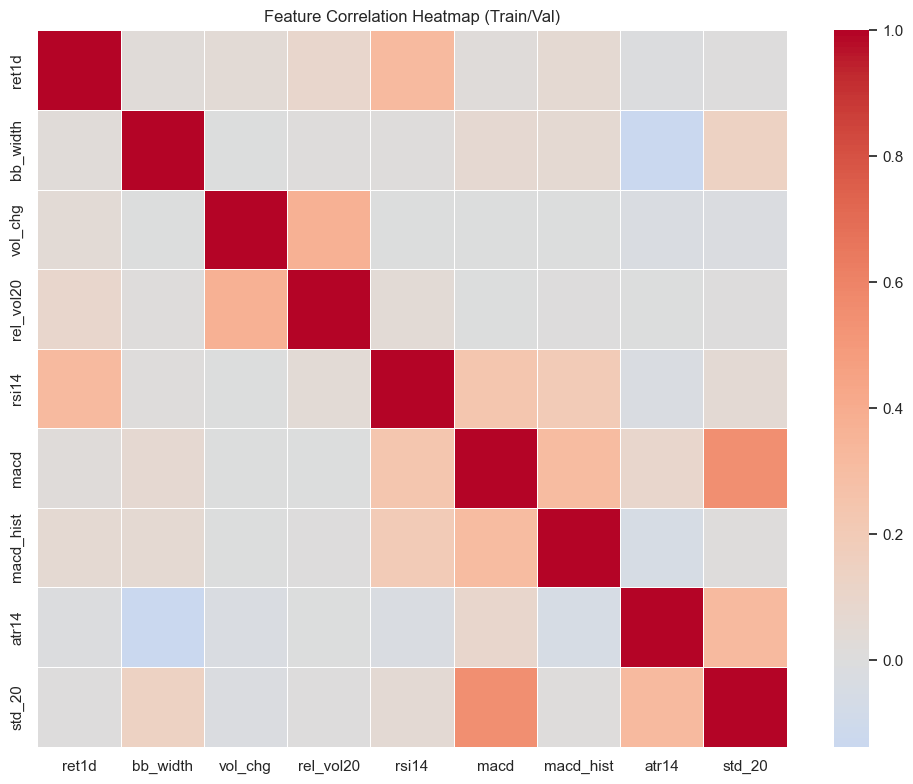

No feature pairs exceed |0.8| correlation.


In [15]:
base_df = train_df
if base_df.empty:
    raise ValueError('No samples available to compute covariance matrix.')
train_features = base_df[FEATURES].copy()
cov_matrix = train_features.cov()
corr_matrix = train_features.corr()
cov_matrix.index.name = cov_matrix.columns.name = None
corr_matrix.index.name = corr_matrix.columns.name = None

display(cov_matrix.round(4))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Feature Correlation Heatmap (Train/Val)')
plt.tight_layout()
plt.show()

tri_upper = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
high_corr = (corr_matrix.where(tri_upper).stack().rename('correlation')
             .reset_index().rename(columns={'level_0': 'feature_i', 'level_1': 'feature_j'}))
high_corr = high_corr[high_corr['correlation'].abs() >= 0.8]
if high_corr.empty:
    print('No feature pairs exceed |0.8| correlation.')
else:
    display(high_corr.sort_values('correlation', key=np.abs, ascending=False).reset_index(drop=True))


## 5. Modeling — XGBoost Classifier


In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, classification_report

X_train = train_balanced_df[FEATURES]
y_train = train_balanced_df['target']
X_val = val_df[FEATURES] if not val_df.empty else pd.DataFrame(columns=FEATURES)
y_val = val_df['target'] if not val_df.empty else pd.Series(dtype=int)
X_test = test_df[FEATURES]
y_test = test_df['target']

model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    n_jobs=-1,
    eval_metric='logloss',
    random_state=42,
    base_score=0.5
)
fit_kwargs = {}
if not X_val.empty:
    fit_kwargs['eval_set'] = [(X_val, y_val)]
    fit_kwargs['verbose'] = False
model.fit(X_train, y_train, **fit_kwargs)

def print_metrics(y_true, proba, name):
    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_true, pred)
    prec = precision_score(y_true, pred, zero_division=0)
    rec = recall_score(y_true, pred, zero_division=0)
    try:
        roc = roc_auc_score(y_true, proba)
        roc_msg = f'{roc:.4f}'
    except ValueError:
        roc_msg = 'not defined'
    print(f'{name} Accuracy: {acc:.4f}')
    print(f'{name} ROC-AUC: {roc_msg}')
    print(f'{name} Precision: {prec:.4f}')
    print(f'{name} Recall: {rec:.4f}')
    return pred

if not X_val.empty:
    val_proba = model.predict_proba(X_val)[:, 1]
    print('Validation Metrics:')
    val_pred = print_metrics(y_val, val_proba, 'Validation')
    print()

test_proba = model.predict_proba(X_test)[:, 1]
print('Test Metrics:')
test_pred = print_metrics(y_test, test_proba, 'Test')
print()
print(classification_report(y_test, test_pred))


Validation Metrics:
Validation Accuracy: 0.5100
Validation ROC-AUC: 0.5135
Validation Precision: 0.5435
Validation Recall: 0.5380

Test Metrics:
Test Accuracy: 0.5100
Test ROC-AUC: 0.5060
Test Precision: 0.5364
Test Recall: 0.5303

              precision    recall  f1-score   support

           0       0.48      0.49      0.48      3128
           1       0.54      0.53      0.53      3500

    accuracy                           0.51      6628
   macro avg       0.51      0.51      0.51      6628
weighted avg       0.51      0.51      0.51      6628



### Feature Ablation — SMA vs. ATR
We benchmark removing `sma` inputs and `atr14` separately while keeping all other features, using the same chronological splits.


In [17]:
def evaluate_feature_subset(name, feature_subset):
    missing = [f for f in feature_subset if f not in train_df.columns]
    if missing:
        raise ValueError(f'Missing features {missing}')
    X_train_sub = train_balanced_df[feature_subset]
    y_train_sub = train_balanced_df['target']
    X_val_sub = val_df[feature_subset] if not val_df.empty else pd.DataFrame(columns=feature_subset)
    y_val_sub = val_df['target'] if not val_df.empty else pd.Series(dtype=int)
    X_test_sub = test_df[feature_subset]
    y_test_sub = test_df['target']

    model_sub = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        n_jobs=-1,
        eval_metric='logloss',
        random_state=42,
        base_score=0.5
    )
    fit_kwargs = {}
    if not X_val_sub.empty:
        fit_kwargs['eval_set'] = [(X_val_sub, y_val_sub)]
        fit_kwargs['verbose'] = False
    model_sub.fit(X_train_sub, y_train_sub, **fit_kwargs)
    print(f'=== {name} ===')
    if not X_val_sub.empty:
        val_proba = model_sub.predict_proba(X_val_sub)[:, 1]
        print('Validation Metrics:')
        _ = print_metrics(y_val_sub, val_proba, 'Validation')
        print()
    test_proba = model_sub.predict_proba(X_test_sub)[:, 1]
    print('Test Metrics:')
    test_pred = print_metrics(y_test_sub, test_proba, 'Test')
    print()
    print(classification_report(y_test_sub, test_pred))
    print('-' * 60)
    return {
        'name': name,
        'val_accuracy': accuracy_score(y_val_sub, (val_proba >= 0.5).astype(int)) if not X_val_sub.empty else None,
        'test_accuracy': accuracy_score(y_test_sub, test_pred)
    }

scenario_features = {
    'Baseline (No SMA)': FEATURES,
    'No ATR14': [f for f in FEATURES if f != 'atr14']
}
ablation_results = []
for name, feats in scenario_features.items():
    ablation_results.append(evaluate_feature_subset(name, feats))
pd.DataFrame(ablation_results)


=== Baseline (No SMA) ===
Validation Metrics:
Validation Accuracy: 0.5100
Validation ROC-AUC: 0.5135
Validation Precision: 0.5435
Validation Recall: 0.5380

Test Metrics:
Test Accuracy: 0.5100
Test ROC-AUC: 0.5060
Test Precision: 0.5364
Test Recall: 0.5303

              precision    recall  f1-score   support

           0       0.48      0.49      0.48      3128
           1       0.54      0.53      0.53      3500

    accuracy                           0.51      6628
   macro avg       0.51      0.51      0.51      6628
weighted avg       0.51      0.51      0.51      6628

------------------------------------------------------------


=== No ATR14 ===
Validation Metrics:
Validation Accuracy: 0.5123
Validation ROC-AUC: 0.5113
Validation Precision: 0.5480
Validation Recall: 0.5160

Test Metrics:
Test Accuracy: 0.5017
Test ROC-AUC: 0.5035
Test Precision: 0.5308
Test Recall: 0.4849

              precision    recall  f1-score   support

           0       0.47      0.52      0.50      3128
           1       0.53      0.48      0.51      3500

    accuracy                           0.50      6628
   macro avg       0.50      0.50      0.50      6628
weighted avg       0.50      0.50      0.50      6628

------------------------------------------------------------


,name,val_accuracy,test_accuracy
0,Baseline (No SMA),0.510038,0.509958
1,No ATR14,0.512302,0.501660


## 6. Feature Importance

We inspect gain-based feature importance from the trained XGBoost model to understand which signals drive the predictions.


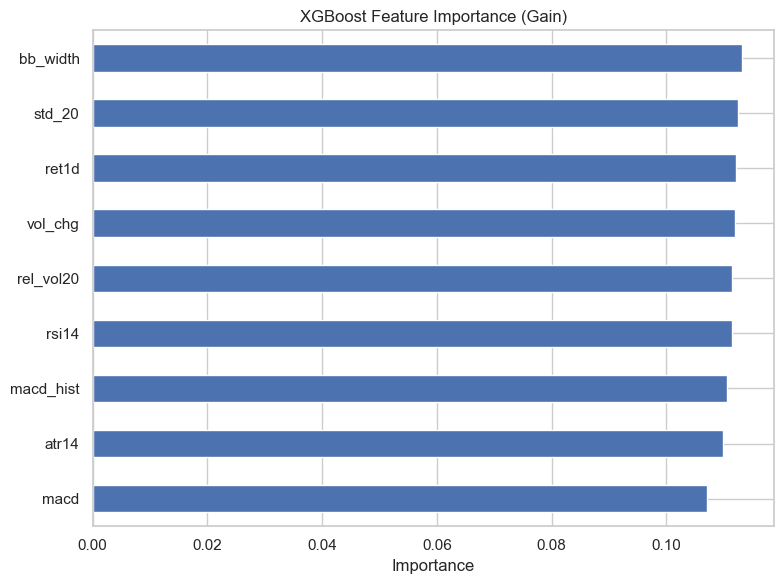

,importance
bb_width,0.113085
std_20,0.112544
ret1d,0.112122
vol_chg,0.111869
rel_vol20,0.111437
rsi14,0.111397
macd_hist,0.110509
atr14,0.109920
macd,0.107116


In [18]:
importances = (pd.Series(model.feature_importances_, index=FEATURES)
               .sort_values(ascending=True))
ax = importances.plot(kind='barh', figsize=(8, 6), title='XGBoost Feature Importance (Gain)')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()
importances.sort_values(ascending=False).to_frame('importance')


## 7. Explainability — SHAP Summary


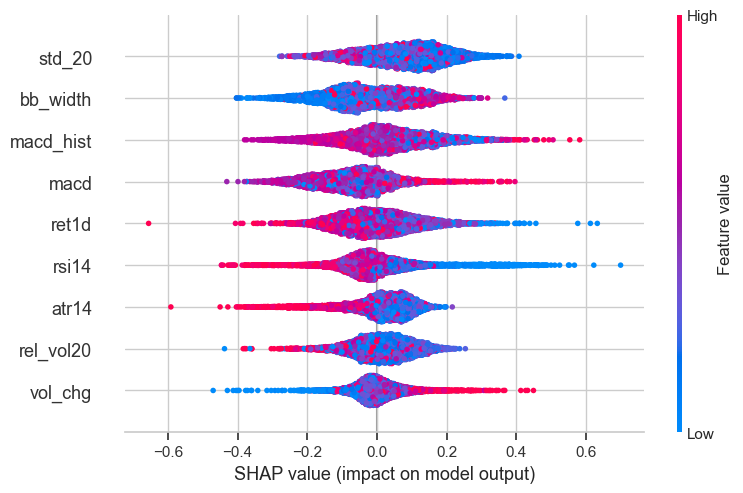

In [19]:
import shap
import xgboost as xgb
dmatrix = xgb.DMatrix(X_test, feature_names=FEATURES)
shap_values = model.get_booster().predict(dmatrix, pred_contribs=True)
shap.summary_plot(shap_values[:, :-1], X_test, feature_names=FEATURES, show=False)
plt.show()


## 8. Live Prediction


In [20]:
def compute_features_latest(df):
    feat_df = add_features(df)
    feat_df = feat_df.dropna(subset=FEATURES)
    return feat_df

def predict_tomorrow(ticker, start=START):
    df = download_ticker(ticker, start=start)
    feat_df = compute_features_latest(df)
    if feat_df.empty:
        raise ValueError('Not enough data to compute features for inference.')
    X_last = feat_df[FEATURES].iloc[[-1]]
    last_date = pd.to_datetime(feat_df['Date'].iloc[-1]).date()
    prob_up = float(model.predict_proba(X_last)[:, 1])
    prediction = int(prob_up >= 0.5)
    return {
        'ticker': ticker,
        'as_of_date': str(last_date),
        'prob_up_next_day': prob_up,
        'prediction': prediction
    }

predict_tomorrow('AAPL')


{'ticker': 'AAPL',
 'as_of_date': '2025-10-24',
 'prob_up_next_day': 0.39679843187332153,
 'prediction': 0}

## 9. Export Artifacts


In [21]:
os.makedirs("data/processed", exist_ok=True)
for t, g in feat.groupby("Ticker"):
    g.to_csv(f"data/processed/{t}_features.csv", index=False)
feat.to_csv("data/processed/pooled_features.csv", index=False)
print("Saved per-ticker features and pooled_features.csv in data/processed/")


Saved per-ticker features and pooled_features.csv in data/processed/


---
### Appendix: Optional Visualization Helper


In [22]:
def plot_probabilities(index_like, proba, title="P(Up) vs. Time"):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(range(len(proba)), proba, label='P(Up)')
    ax.set_title(title)
    ax.legend()
    plt.show()
